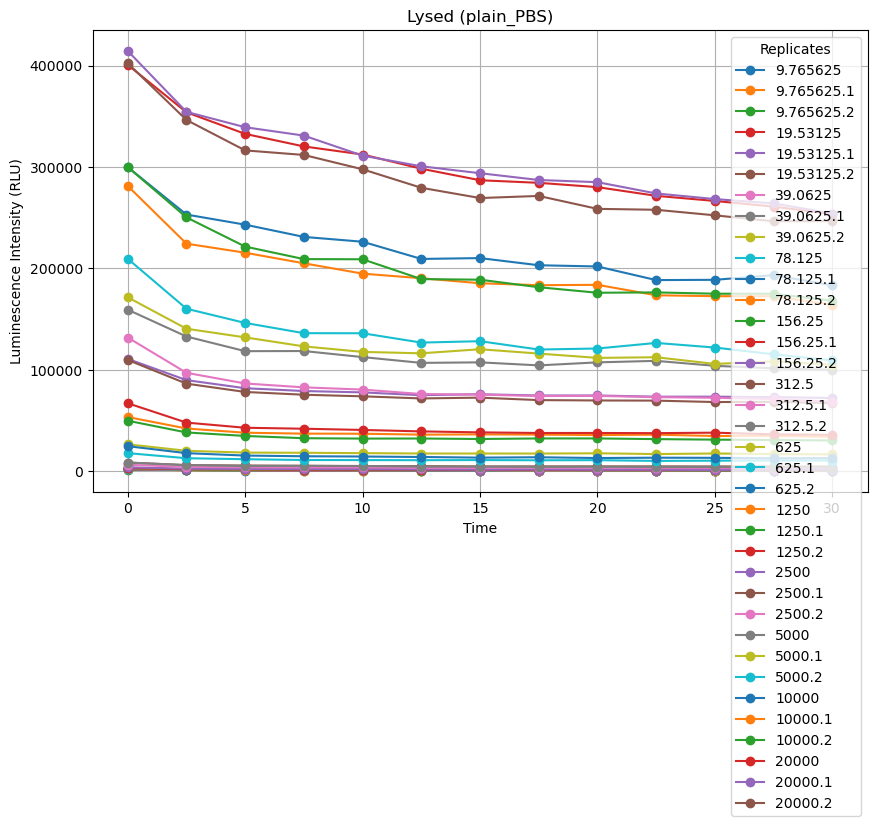

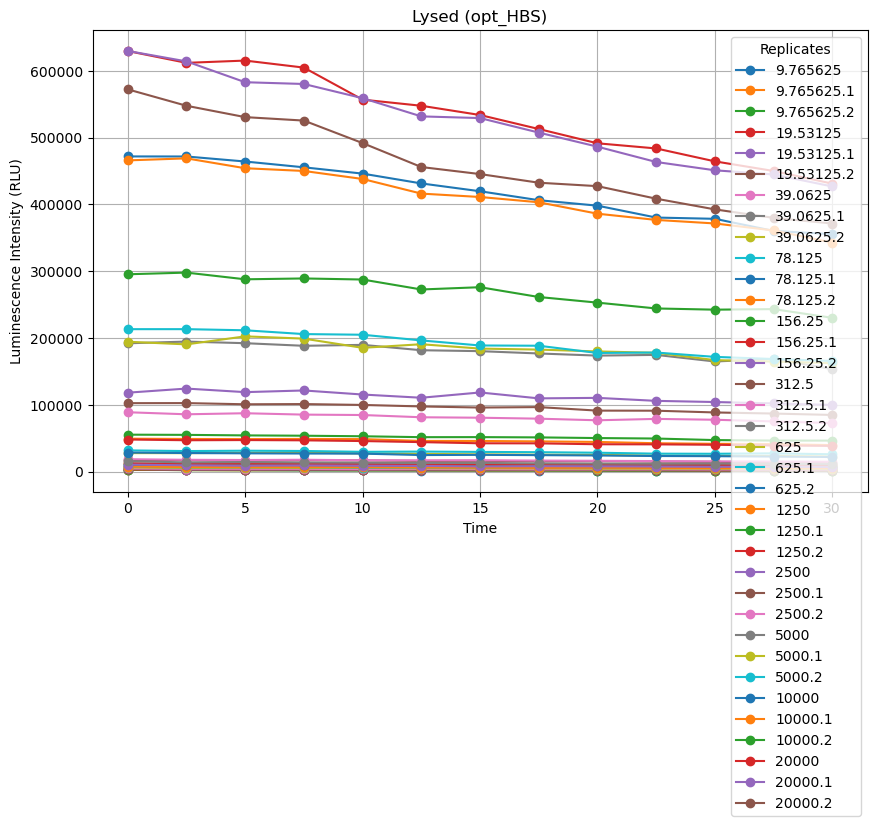

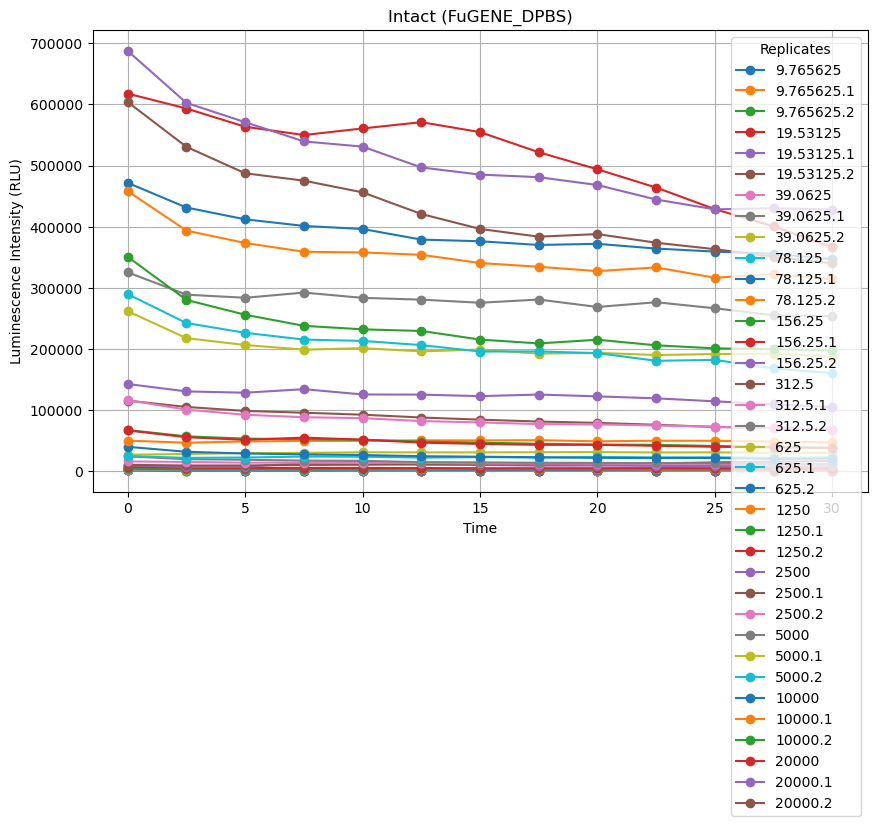

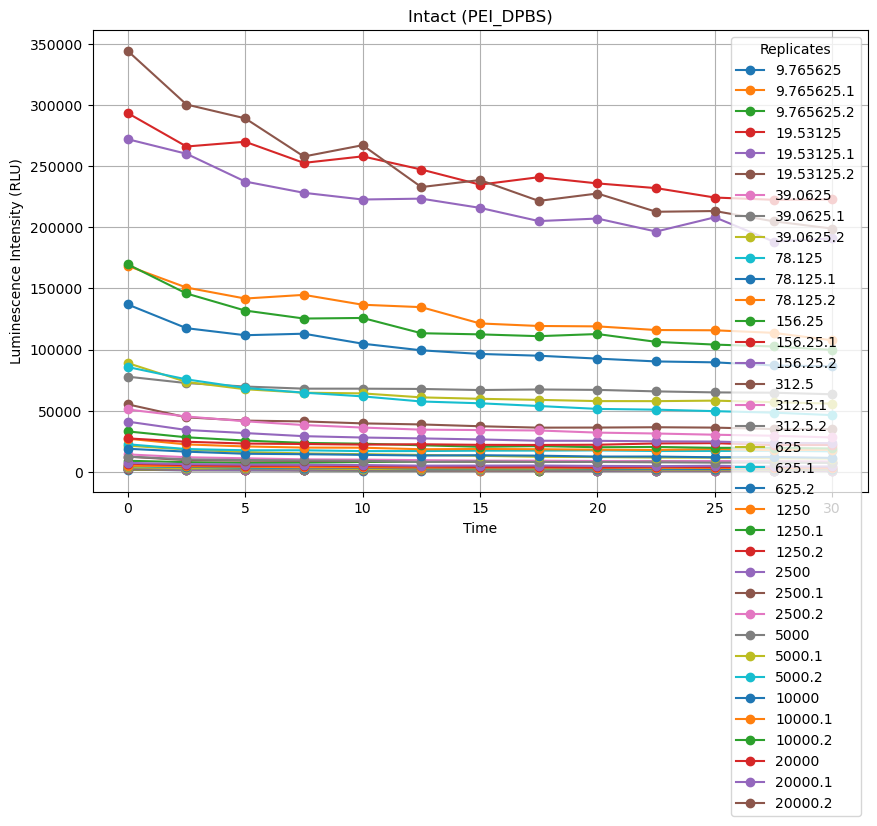

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file with all sheets
excel_file = 'LuxPro (1C).xlsx'
all_data = pd.read_excel(excel_file, sheet_name=None)

# Loop through each condition (sheet)
for condition, df in all_data.items():
    # Assume the first column is time and the remaining columns are replicates
    time = df.iloc[:, 0]  # time points
    data = df.iloc[:, 1:]  # RLU values for replicates

    plt.figure(figsize=(10, 6))
    for col in data.columns:
        plt.plot(time, data[col], marker='o', label=str(col))
    plt.title(condition)
    plt.xlabel("Time")
    plt.ylabel("Luminescence Intensity (RLU)")
    plt.legend(title='Replicates')
    plt.grid(True)
    plt.show()


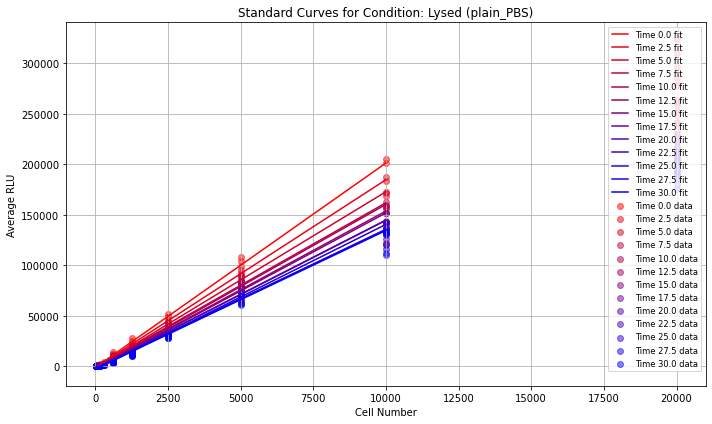

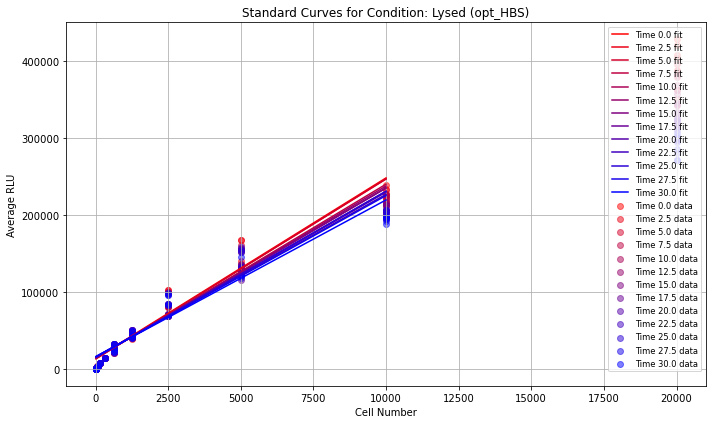

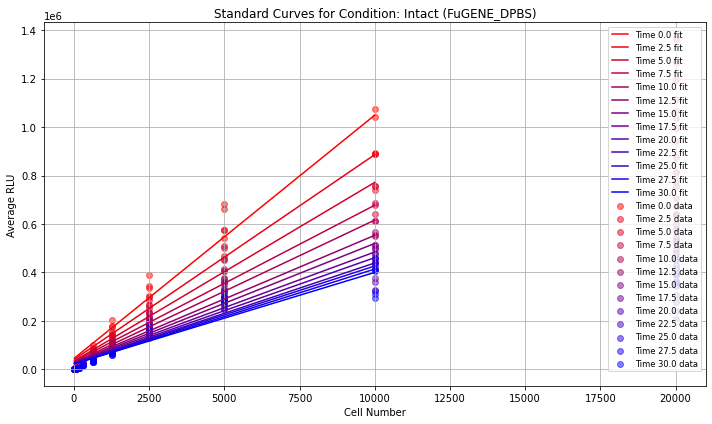

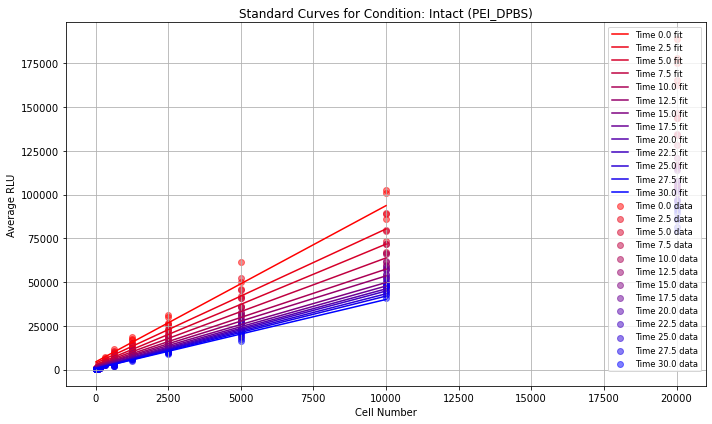

Fitting parameters saved to 'fitting_parameters.csv'


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import re
from matplotlib.colors import LinearSegmentedColormap

# --- Configuration parameters ---
excel_file = 'NeonGreen.xlsx'
min_points = 3  # minimum number of points required for regression

def extract_float(s):
    """
    Extract the first float number from a string.
    For example, '156.25.1' will return 156.25.
    """
    match = re.match(r"^\d+(?:\.\d+)?", s)
    if match:
        return float(match.group(0))
    else:
        raise ValueError(f"Cannot extract float from header: {s}")

# Read all sheets from the Excel file; each sheet corresponds to a condition.
sheets = pd.read_excel(excel_file, sheet_name=None)

# List to store fitting parameters for each condition and time point.
fit_results = []

# Process each condition (each sheet)
for condition, df in sheets.items():
    # The first row contains the header.
    # The first column contains time points.
    time_points = df.iloc[:, 0]
    
    # Process replicate columns (columns from index 1 onward).
    replicate_cols = df.columns[1:]
    # Extract the numeric part from each header (e.g. "156.25.1" becomes 156.25)
    new_names = [extract_float(str(col)) for col in replicate_cols]
    
    # Create a new DataFrame with updated column names.
    df_new = df.copy()
    df_new.columns = [df.columns[0]] + new_names  # first column remains unchanged
    
    # Group columns with the same cell number and average the triplicates.
    grouped = df_new.iloc[:, 1:].groupby(level=0, axis=1).mean()
    
    # Get the sorted unique cell numbers (x-values).
    cell_numbers = np.array(grouped.columns, dtype=float)
    sort_idx = np.argsort(cell_numbers)
    x_sorted = cell_numbers[sort_idx]
    
    # --- Set up a colormap for time points: red (early) to blue (late) ---
    cmap = LinearSegmentedColormap.from_list("red_to_blue", ["red", "blue"])
    norm = plt.Normalize(vmin=0, vmax=len(time_points)-1)
    
    plt.figure(figsize=(10, 6))
    
    # Process each time point (each row in the grouped DataFrame)
    for idx, t in enumerate(time_points):
        # Get color for this time point based on its order.
        color = cmap(norm(idx))
        
        # Get the averaged RLU values for this time point.
        y_vals = grouped.iloc[idx].values.astype(float)
        # Reorder the y-values according to the sorted cell numbers.
        y_sorted = y_vals[sort_idx]
        
        # --- Filter data: only include cell numbers in the fixed range [10, 10000] ---
        mask = (x_sorted >= 10) & (x_sorted <= 10000)
        if np.sum(mask) < min_points:
            # Not enough data points in the fixed range for a proper regression.
            continue
        
        x_fixed = x_sorted[mask]
        y_fixed = y_sorted[mask]
        
        # Perform linear regression on the fixed range.
        slope, intercept, r_value, p_value, std_err = linregress(x_fixed, y_fixed)
        r2 = r_value**2
        
        # Calculate additional regression parameters.
        x_intercept = -intercept / slope if slope != 0 else np.nan
        inv_slope = 1.0 / slope if slope != 0 else np.nan
        
        # Calculate Sy.x: the standard error of the estimate.
        y_fit = slope * x_fixed + intercept
        n = len(x_fixed)
        syx = np.sqrt(np.sum((y_fixed - y_fit)**2) / (n - 2)) if n > 2 else np.nan
        
        # Calculate LOD = 3.3 * Sy.x / slope.
        lod = 3.3 * syx / slope if slope != 0 else np.nan
        
        # Save the fitting parameters.
        fit_results.append({
            "Condition": condition,
            "Time": t,
            "Slope": slope,
            "Y-intercept": intercept,
            "X-intercept": x_intercept,
            "1/slope": inv_slope,
            "R squared": r2,
            "Sy.x": syx,
            "LOD": lod
        })
        
        # --- Plotting the data and fitted line ---
        # Scatter plot the averaged data points (all points for context).
        plt.scatter(x_sorted, y_sorted, color=color, alpha=0.5, label=f'Time {t} data')
        
        # Plot the fitted line over the fixed range.
        x_line = np.linspace(np.min(x_fixed), np.max(x_fixed), 100)
        y_line = slope * x_line + intercept
        plt.plot(x_line, y_line, color=color, label=f'Time {t} fit')
    
    plt.title(f'Standard Curves for Condition: {condition}')
    plt.xlabel('Cell Number')
    plt.ylabel('Average RLU')
    plt.legend(fontsize='small', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Save all fitting parameters into a CSV file.
fit_df = pd.DataFrame(fit_results)
fit_df.to_csv('fitting_parameters.csv', index=False)
print("Fitting parameters saved to 'fitting_parameters.csv'")



Processed Table for Condition: Lysed (HBSS)
          9.0          19.0         39.0         78.0         156.0    \
0.0   2354.666667  3068.000000  3679.000000  5215.000000  6816.000000   
2.5   1780.666667  2264.333333  2819.666667  3883.000000  5747.000000   
5.0   1710.666667  2181.666667  2544.000000  3474.000000  5067.333333   
7.5   1447.000000  1843.000000  2343.666667  3365.333333  4926.666667   
10.0  1336.333333  1718.333333  2200.333333  3367.333333  4734.666667   
12.5  1253.333333  1735.333333  1954.333333  3182.333333  4437.666667   
15.0  1181.000000  1539.666667  1876.666667  3063.666667  4318.666667   
17.5  1140.333333  1526.000000  1905.000000  3137.333333  4345.333333   
20.0  1015.666667  1466.000000  1723.666667  2687.333333  4135.000000   
22.5   980.666667  1406.666667  1726.000000  2668.333333  3930.333333   
25.0   984.333333  1413.333333  1656.000000  2632.000000  3863.666667   
27.5  1067.333333  1264.333333  1563.000000  2557.000000  3651.333333   
30.0  

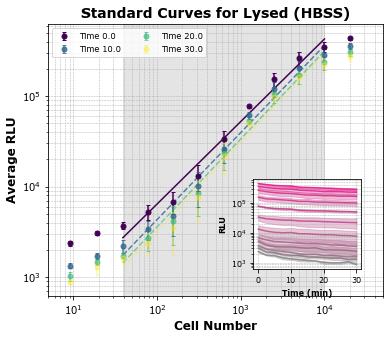


Processed Table for Condition: Lysed (opt_HBS)
          9.0          19.0         39.0         78.0          156.0    \
0.0   2816.000000  4417.000000  7269.666667  9545.000000  13174.666667   
2.5   2408.666667  3851.333333  6535.000000  8720.333333  12477.333333   
5.0   2268.000000  3741.000000  6626.000000  8546.666667  12101.333333   
7.5   2246.333333  3508.333333  6419.333333  8491.666667  11966.333333   
10.0  2136.000000  3608.666667  6294.666667  8348.000000  11977.000000   
12.5  1961.666667  3262.666667  5860.000000  8015.333333  11512.000000   
15.0  1824.666667  3167.333333  5823.333333  7707.333333  11230.333333   
17.5  1701.666667  3095.000000  5823.666667  7857.000000  10720.333333   
20.0  1835.333333  2911.000000  5753.000000  7381.333333  10780.333333   
22.5  1760.666667  3038.666667  5646.666667  7501.000000  10849.000000   
25.0  1681.000000  3050.000000  5551.333333  7487.333333  10526.666667   
27.5  1634.000000  3092.000000  5513.666667  7546.000000  10535.

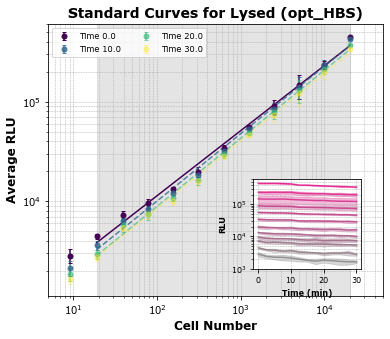


Processed Table for Condition: Intact (FuGENE_HBSS)
          9.0          19.0         39.0         78.0          156.0    \
0.0   1850.666667  2916.666667  3172.333333  6842.333333  15739.000000   
2.5   1343.000000  2223.666667  2242.000000  5861.666667  13263.333333   
5.0   1165.000000  2002.000000  2124.666667  5819.000000  12045.333333   
7.5   1043.666667  1854.333333  1988.666667  5490.000000  11599.333333   
10.0  1084.333333  1777.333333  2030.333333  5459.000000  11156.000000   
12.5   825.000000  1717.000000  1888.333333  4926.666667  10353.333333   
15.0   800.666667  1655.666667  1643.000000  4811.666667   9995.333333   
17.5   785.333333  1468.000000  1616.333333  4731.000000   9534.000000   
20.0   729.333333  1521.000000  1566.000000  4644.666667   9377.333333   
22.5   803.333333  1428.333333  1544.333333  4457.333333   9245.000000   
25.0   738.666667  1338.000000  1571.333333  4400.333333   8978.000000   
27.5   674.333333  1338.333333  1626.666667  4103.666667   

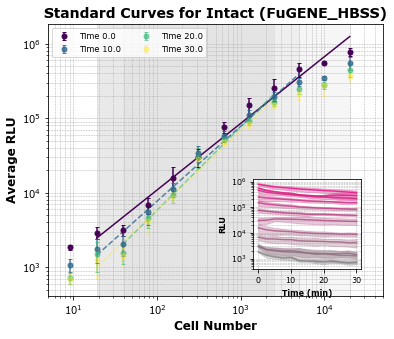


Processed Table for Condition: Intact (PEI_HBSS)
          9.0          19.0         39.0         78.0         156.0    \
0.0   2026.666667  2695.333333  3295.666667  3813.666667  5097.333333   
2.5   1616.000000  2105.000000  2701.333333  3184.333333  4608.000000   
5.0   1349.666667  1796.000000  2405.333333  3213.666667  4335.333333   
7.5   1254.333333  1572.333333  2254.333333  2860.333333  4135.666667   
10.0  1199.000000  1483.666667  2053.000000  2803.666667  3786.333333   
12.5  1080.000000  1383.000000  1828.666667  2356.333333  3471.000000   
15.0  1012.333333  1320.666667  1689.000000  2295.333333  3322.333333   
17.5   949.666667  1209.333333  1579.333333  2234.333333  3445.000000   
20.0   781.666667  1190.666667  1682.000000  2289.333333  3264.000000   
22.5   820.333333  1241.333333  1533.333333  2026.000000  3213.333333   
25.0   869.000000  1217.000000  1497.000000  1980.666667  3011.000000   
27.5   769.666667  1099.333333  1453.333333  1982.333333  2876.666667   
3

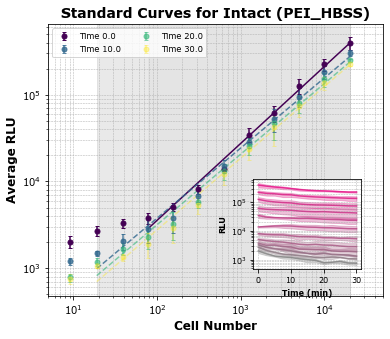

Fitting parameters saved to 'LuxPro_fitting_parameters.csv'


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import re
import matplotlib
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Configuration parameters ---
excel_file = 'LuxPro (DTZ).xlsx'
min_points = 3
selected_times = [0, 10, 20, 30]
r2_threshold = 0.98
start_idx_min = 1  # 5th point (0-indexed)
start_idx_max = 9  # 10th point

# Plot style settings
plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['font.weight'] = 'light'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['text.color'] = 'black'

# Helper functions
def clean_header(s):
    return float(str(s).split('.')[0])

def create_custom_colormap():
    return LinearSegmentedColormap.from_list("pink_to_gray", ['gray', '#ee0284'])

def find_linear_range(x_sorted, y_sorted, r2_thresh=0.98):
    best_range = (None, None)
    best_r2 = 0

    for i in range(start_idx_min, start_idx_max + 1):
        for j in range(i + min_points, len(x_sorted)):
            x_try = x_sorted[i:j+1]
            y_try = y_sorted[i:j+1]
            if len(x_try) < min_points:
                continue

            log_x = np.log10(x_try)
            log_y = np.log10(y_try)
            slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

            if r_value**2 >= r2_thresh and (j - i) > (best_range[1] - best_range[0] if best_range[0] is not None else -1):
                best_range = (i, j)
                best_r2 = r_value**2

    if best_range[0] is not None:
        return x_sorted[best_range[0]], x_sorted[best_range[1]]
    else:
        return None, None

# Read all sheets with first column as index
sheets = pd.read_excel(excel_file, sheet_name=None, index_col=0)

fit_results = []

for condition, df in sheets.items():
    time_points = df.index
    replicate_cols = df.columns
    new_names = [clean_header(col) for col in replicate_cols]
    df_new = df.copy()
    df_new.columns = new_names

    # Fully clean table: average all replicates by cell number
    grouped = df_new.T.groupby(level=0).mean().T
    grouped_std = df_new.T.groupby(level=0).std().T

    # Build the final clean matrix
    clean_table = pd.DataFrame(index=time_points)
    clean_table_std = pd.DataFrame(index=time_points)

    for cell_num in grouped.columns.unique():
        clean_table[cell_num] = grouped[cell_num]
        clean_table_std[cell_num] = grouped_std[cell_num]

    # Sort columns by increasing cell number
    clean_table = clean_table.reindex(sorted(clean_table.columns), axis=1)
    clean_table_std = clean_table_std.reindex(sorted(clean_table_std.columns), axis=1)

    print(f"\nProcessed Table for Condition: {condition}")
    print(clean_table)

    x_sorted = np.array(clean_table.columns)

    cmap_main = cm.get_cmap('viridis')
    norm_main = Normalize(vmin=min(selected_times), vmax=max(selected_times))
    cmap_insert = create_custom_colormap()

    fig, ax_main = plt.subplots(figsize=(6, 5))

    for idx, t in enumerate(time_points):
        if t not in selected_times:
            continue

        color = cmap_main(norm_main(t))
        alpha = 1.0 - (t / max(selected_times)) * 0.6
        line_style = '-' if t == 0 else '--'

        y_vals = clean_table.loc[t].values
        y_errs = clean_table_std.loc[t].values

        x_valid = x_sorted
        y_valid = y_vals
        y_valid_err = y_errs

        valid_mask = (~np.isnan(y_valid)) & (y_valid > 0)
        x_valid = x_valid[valid_mask]
        y_valid = y_valid[valid_mask]
        y_valid_err = y_valid_err[valid_mask]

        ax_main.errorbar(x_valid, y_valid, yerr=y_valid_err, fmt='o', color=color, alpha=alpha, ecolor=color, capsize=2, markersize=5, label=f'Time {t}')

        if len(x_valid) < min_points:
            continue

        # Automatically search best linear range
        fit_min, fit_max = find_linear_range(x_valid, y_valid, r2_thresh=r2_threshold)

        if fit_min is None or fit_max is None:
            continue

        fit_mask = (x_valid >= fit_min) & (x_valid <= fit_max)
        x_fit = x_valid[fit_mask]
        y_fit = y_valid[fit_mask]

        if len(x_fit) < min_points:
            continue

        log_x = np.log10(x_fit)
        log_y = np.log10(y_fit)

        slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
        r2 = r_value**2

        x_intercept = 10**(-intercept / slope) if slope != 0 else np.nan
        inv_slope = 1.0 / slope if slope != 0 else np.nan

        y_fit_log = slope * log_x + intercept
        n = len(log_x)
        syx = np.sqrt(np.sum((y_fit - 10**y_fit_log)**2) / (n - 2)) if n > 2 else np.nan
        lod = 3.3 * syx / slope if slope != 0 else np.nan

        fit_results.append({
            "Condition": condition,
            "Time": t,
            "Slope": slope,
            "Y-intercept (log scale)": intercept,
            "X-intercept": x_intercept,
            "1/slope": inv_slope,
            "R squared": r2,
            "Sy.x": syx,
            "LOD": lod
        })

        # Plot shaded region for linear range
        ax_main.axvspan(fit_min, fit_max, color='lightgray', alpha=0.2)

        # Plot fitted curve
        log_x_line = np.linspace(np.min(log_x), np.max(log_x), 200)
        log_y_line = slope * log_x_line + intercept
        x_line = 10**log_x_line
        y_line = 10**log_y_line
        ax_main.plot(x_line, y_line, line_style, color=color, alpha=alpha)

    ax_main.set_xscale('log')
    ax_main.set_yscale('log')
    ax_main.set_xlim(5, 5e4)
    ax_main.set_xlabel('Cell Number')
    ax_main.set_ylabel('Average RLU')
    ax_main.set_title(f'Standard Curves for {condition}')
    ax_main.grid(True, which='both', ls='--', lw=0.5)
    ax_main.legend(fontsize='x-small', loc='best', ncol=2)

    # Insert plot using inset_axes
    ax_inset = fig.add_axes([0.6, 0.2, 0.25, 0.25])

    for i, cell_number in enumerate(x_sorted):
        y_curve = clean_table[cell_number]
        y_std_curve = clean_table_std[cell_number]
        if y_curve.isnull().all():
            continue

        color_insert = create_custom_colormap()(i / len(x_sorted))
        ax_inset.plot(time_points, y_curve, '-', color=color_insert, alpha=0.8)
        ax_inset.fill_between(time_points, y_curve - y_std_curve, y_curve + y_std_curve, color=color_insert, alpha=0.3)

    ax_inset.set_xlabel('Time (min)', fontsize=8)
    ax_inset.set_ylabel('RLU', fontsize=8)
    ax_inset.set_yscale('log')
    ax_inset.tick_params(axis='both', which='major', labelsize=8)
    ax_inset.grid(True, which='both', ls='--', lw=0.5)

    plt.show()

# Save fitting parameters
fit_df = pd.DataFrame(fit_results)
fit_df.to_csv('LuxPro-DTZ_fitting_parameters.csv', index=False)
print("Fitting parameters saved to 'LuxPro_fitting_parameters.csv'")